In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install chromadb --quiet
!pip install nltk --quiet
!pip install sentence-transformers --quiet
!pip install PdfReader

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires kubernetes<27,>=8.0.0, but you have kubernetes 31.0.0 which is incompatible.


In [39]:
import chromadb
import pandas as pd
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
from pypdf import PdfReader
import re

# Read PDF File

In [52]:
reader = PdfReader('/kaggle/input/test-pdf/Test.pdf')
document_text = ""
#document_text = reader.pages[0].extract_text()
for i in range(1,3):#len(reader.pages)):
    document_text = document_text + "\n" + reader.pages[i].extract_text()
#print(document_text)

In [5]:
client = chromadb.Client()
collection = client.create_collection(name = "MyFirstCollection")

In [4]:
doc1 = "Operating the Climate Control System  Your Googlecar has a climate control system that allows you to adjust the temperature and airflow in the car. To operate the climate control system, use the buttons and knobs located on the center console.  Temperature: The temperature knob controls the temperature inside the car. Turn the knob clockwise to increase the temperature or counterclockwise to decrease the temperature. Airflow: The airflow knob controls the amount of airflow inside the car. Turn the knob clockwise to increase the airflow or counterclockwise to decrease the airflow. Fan speed: The fan speed knob controls the speed of the fan. Turn the knob clockwise to increase the fan speed or counterclockwise to decrease the fan speed. Mode: The mode button allows you to select the desired mode. The available modes are: Auto: The car will automatically adjust the temperature and airflow to maintain a comfortable level. Cool: The car will blow cool air into the car. Heat: The car will blow warm air into the car. Defrost: The car will blow warm air onto the windshield to defrost it."
doc2 = 'Your Googlecar has a large touchscreen display that provides access to a variety of features, including navigation, entertainment, and climate control. To use the touchscreen display, simply touch the desired icon.  For example, you can touch the "Navigation" icon to get directions to your destination or touch the "Music" icon to play your favorite songs.'
doc3 = "Shifting Gears Your Googlecar has an automatic transmission. To shift gears, simply move the shift lever to the desired position.  Park: This position is used when you are parked. The wheels are locked and the car cannot move. Reverse: This position is used to back up. Neutral: This position is used when you are stopped at a light or in traffic. The car is not in gear and will not move unless you press the gas pedal. Drive: This position is used to drive forward. Low: This position is used for driving in snow or other slippery conditions."

documents = [doc1, doc2, doc3]

In [7]:
emb = collection.get(
    include=["embeddings"]
)['embeddings']

# Sentence Embeddings

In [5]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Context based Sentence Chunking
- Split the sentences using nltk sentence tokenizer
- Iteratively generate embeddings for each sentence
- Perform cosine similarity to combine the sentences

In [56]:
def contextual_embeddings(sent_list, threshold=0.1):    
    src_list = []
    dst_list = []
    dist_list = []
    chunk = []
    chunk_emb = []
    thresh = 0.1
    concat_sent = ""
    prev_dist = -1
    count_sent = 0
    
    for i in range(len(sent_list)-1):
        concat_sent += sent_list[i]
        src_emb = np.array(model.encode(concat_sent))
        dst_emb = np.array(model.encode(sent_list[i+1]))
        dist = cosine_similarity([src_emb], [dst_emb])[0][0]
        if dist + thresh < prev_dist or count_sent > 5:
            chunk.append(concat_sent)
            chunk_emb.append(src_emb)
            concat_sent = ""
            count_sent = 0
            prev_dist = -1
        else:
            count_sent += 1
            prev_dist = dist
        src_list.append(concat_sent)
        dst_list.append(sent_list[i+1])
        dist_list.append(dist)
    return chunk, chunk_emb, src_list, dst_list, dist_list

In [42]:
def text_preprocessing(doc_text):
    sentences = sent_tokenize(doc_text) # Tokenize sentences
    sentences = [re.sub(r"[\n]", "", item) for item in sentences]
    return sentences

In [57]:
chunk, chunk_embeddings, src_list, dst_list, dist_list = contextual_embeddings(text_preprocessing(document_text), threshold=0.1)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
d = {'src': src_list, 'dest': dst_list, 'distance': dist_list}
df = pd.DataFrame(d)

In [61]:
df.to_csv("semanticchunks.csv")

In [12]:
concat_doc = doc1 + " " + doc2 + " " + doc3

In [55]:
chunk

['Therefore, a novel hybrid architecture combining  CNN with LSTM  networks for RUL estimation is developed in this paper.Although CNN -based LSTM models have been applied to sequence prediction tasks in financial forecasting, this is the first attempt to adopt this approach for RUL estimation in prognostics.In the proposed architecture for RUL estimation, one dimensional convolutional filters in the initial layer are applied to all the sensor data at each time stamp followed by LSTM layers applied temporally over the time series and the final neural network regression layer employs squared error loss function.In this approach,  the CNN layer efficiently extract s features from the data, followed by LSTM  layer , which uses these extracted features to predict RUL.',
 'This method effectively l everages sensor sequence information, uncovering hidden patterns within the data, even under multiple operating conditions and fault scenarios .Data -driven approaches involve several key steps, 

In [14]:
concat_list = []
sent_list = sent_tokenize(concat_doc)
concat_sent = ""
for i in range(len(sent_list)):    
    concat_sent += sent_list[i]
    concat_emb = np.array(model.encode(concat_sent))
    concat_list.append(concat_emb)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
cos_dist = []
for i in range(len(concat_list)-1):
    dist = cosine_similarity(concat_list[i].reshape(1,-1), concat_list[i+1].reshape(1,-1))[0][0]
    cos_dist.append(dist)


In [16]:
sent_list

['Operating the Climate Control System  Your Googlecar has a climate control system that allows you to adjust the temperature and airflow in the car.',
 'To operate the climate control system, use the buttons and knobs located on the center console.',
 'Temperature: The temperature knob controls the temperature inside the car.',
 'Turn the knob clockwise to increase the temperature or counterclockwise to decrease the temperature.',
 'Airflow: The airflow knob controls the amount of airflow inside the car.',
 'Turn the knob clockwise to increase the airflow or counterclockwise to decrease the airflow.',
 'Fan speed: The fan speed knob controls the speed of the fan.',
 'Turn the knob clockwise to increase the fan speed or counterclockwise to decrease the fan speed.',
 'Mode: The mode button allows you to select the desired mode.',
 'The available modes are: Auto: The car will automatically adjust the temperature and airflow to maintain a comfortable level.',
 'Cool: The car will blow coo

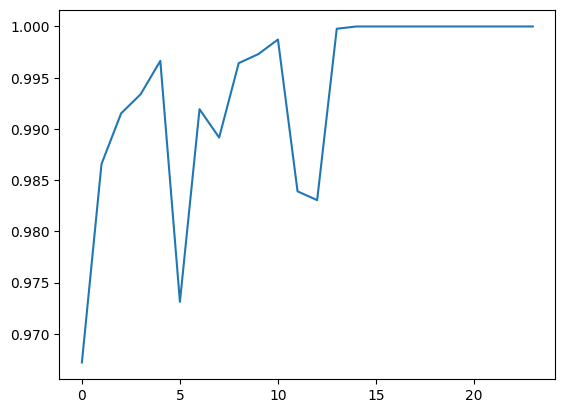

In [17]:
import matplotlib.pyplot as plt

plt.plot(cos_dist)

In [18]:
doc1_emb = np.array(model.encode(doc1))
doc2_emb = np.array(model.encode(doc2))
doc3_emb = np.array(model.encode(doc3))
a = cosine_similarity(doc1_emb.reshape(-1,1), doc2_emb.reshape(-1,1))[0][0]
b = cosine_similarity(doc2_emb.reshape(-1,1), doc3_emb.reshape(-1,1))[0][0]
c = cosine_similarity(doc1_emb.reshape(-1,1), doc3_emb.reshape(-1,1))[0][0]
print(a,b,c)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

-1.0 -1.0 1.0


In [19]:
len(sent_tokenize(doc1)), len(sent_tokenize(doc2)), len(sent_tokenize(doc3))

(13, 3, 9)